# Model Training
Train the model from the /train folder. Gets class types through the names of folders each image is in. Then saves the model to the project directory.

In [1]:
import numpy as np
import tensorflow as tf
import cv2

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras_visualizer import visualizer 

In [2]:
import pathlib

DATA_DIR = pathlib.Path("./train")
IMAGE_COUNT = len(list(DATA_DIR.glob('*/*.jpg')))
print(IMAGE_COUNT)

4208


In [3]:
BATCH_SIZE = 64
IMG_HEIGHT = 48
IMG_WIDTH = 48

INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 1)

train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  color_mode="grayscale")

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  color_mode="grayscale")

CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)

print(CLASS_NAMES)

Found 4208 files belonging to 26 classes.
Using 3367 files for training.
Found 4208 files belonging to 26 classes.
Using 841 files for validation.
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'qu', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### Example Data Image + Labels

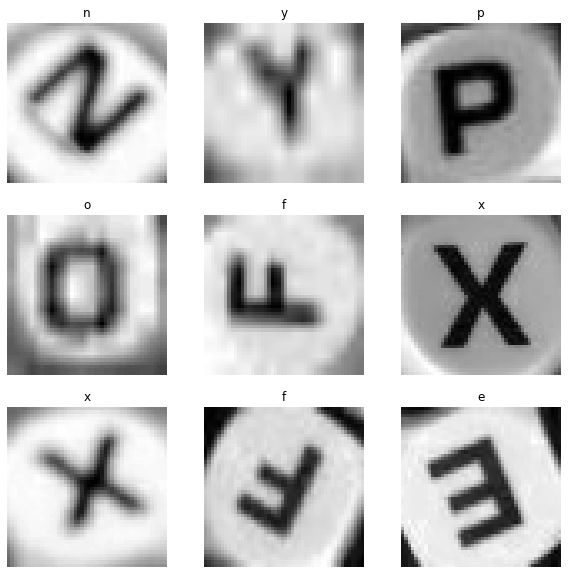

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title(CLASS_NAMES[labels[i]])
    plt.axis("off")

### Model Creation

In [5]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
WEIGHT_DECAY = 0.0008

model = Sequential([
  # the following three data augmentation layers are not allowed in TFJS
  # layers.Resizing(img_height, img_width, input_shape=(img_height, img_width, 3)),
  # layers.Rescaling(1./255),
  # layers.RandomRotation(0.2),
  layers.Conv2D(
    32,
    kernel_size = (3, 3),
    activation = "relu",
    input_shape = INPUT_SHAPE,
    kernel_regularizer=tf.keras.regularizers.L1L2(l1=0, l2=WEIGHT_DECAY),
    bias_regularizer=tf.keras.regularizers.L1L2(l1=0, l2=WEIGHT_DECAY)
  ),
  layers.Conv2D(
    64,
    (3, 3),
    activation = "relu",
    kernel_regularizer=tf.keras.regularizers.L1L2(l1=0, l2=WEIGHT_DECAY),
    bias_regularizer=tf.keras.regularizers.L1L2(l1=0, l2=WEIGHT_DECAY)
  ),
  layers.Conv2D(
    128,
    (4, 4), 
    activation = "relu", 
    kernel_regularizer=tf.keras.regularizers.L1L2(l1=0, l2=WEIGHT_DECAY),
    bias_regularizer=tf.keras.regularizers.L1L2(l1=0, l2=WEIGHT_DECAY)
  ),
  layers.MaxPooling2D(pool_size = (2, 2)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(
    128, 
    activation = 'relu', 
    kernel_regularizer=tf.keras.regularizers.L1L2(l1=0, l2=WEIGHT_DECAY),
    bias_regularizer=tf.keras.regularizers.L1L2(l1=0, l2=WEIGHT_DECAY)
  ),
  layers.Dropout(0.5),
  layers.Dense(NUM_CLASSES, activation = "softmax"),
])

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()
# visualizer(model, format='png', view=True) # visualize the model as an image

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       131200    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 20, 128)       0         
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                        

### Train

In [6]:
EPOCHS = 100
model_folder = "./model/"
model_weights_best = model_folder + "roggle_letter_classifier.weights.best.hdf5"


# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = model_weights_best, 
                               verbose = 2, 
                               save_best_only = True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=4, 
                                 verbose=2, 
                                 factor=.75)

# If score doesn't improve, stop learning
estopping = EarlyStopping(monitor='val_loss', 
                          patience=5, 
                          verbose=2)

history = model.fit(
  train_ds,
  batch_size = BATCH_SIZE,
  verbose = 1,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks = [checkpointer, lr_reduction, estopping]
)

Epoch 1/100
53/53 [==============================] - ETA: 0s - loss: 13.8185 - accuracy: 0.1060
Epoch 1: val_loss improved from inf to 3.12007, saving model to ./model\roggle_letter_classifier.weights.best.hdf5
53/53 [==============================] - 79s 1s/step - loss: 13.8185 - accuracy: 0.1060 - val_loss: 3.1201 - val_accuracy: 0.2212 - lr: 0.0010
Epoch 2/100
53/53 [==============================] - ETA: 0s - loss: 3.2558 - accuracy: 0.1758
Epoch 2: val_loss improved from 3.12007 to 2.97906, saving model to ./model\roggle_letter_classifier.weights.best.hdf5
53/53 [==============================] - 65s 1s/step - loss: 3.2558 - accuracy: 0.1758 - val_loss: 2.9791 - val_accuracy: 0.2652 - lr: 0.0010
Epoch 3/100
53/53 [==============================] - ETA: 0s - loss: 3.0014 - accuracy: 0.2432
Epoch 3: val_loss improved from 2.97906 to 2.66717, saving model to ./model\roggle_letter_classifier.weights.best.hdf5
53/53 [==============================] - 73s 1s/step - loss: 3.0014 - accura

In [7]:
# save the final model
model_name = "roggle_letter_classifier"
model_path = model_folder + model_name
model.save_weights(model_path)
model.save(model_path, save_format='h5')

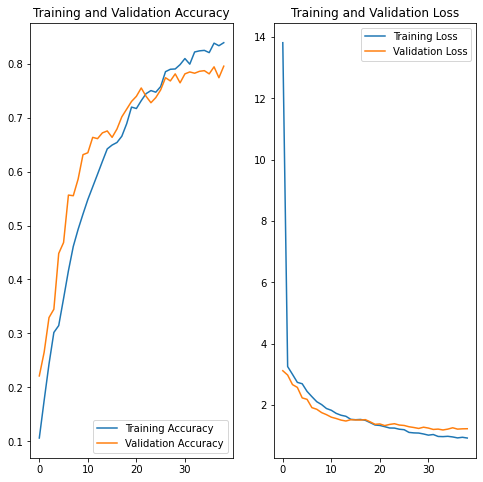

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(estopping.stopped_epoch + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference

test/e.jpg
1/1 [==============================] - 0s 122ms/step



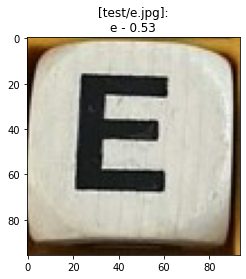

test/h.jpg
1/1 [==============================] - 0s 46ms/step



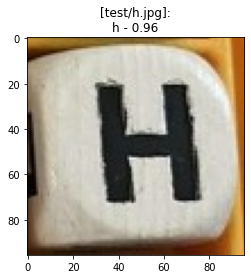

test/n.jpg
1/1 [==============================] - 0s 41ms/step



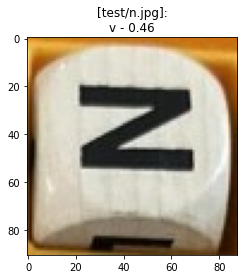

test/n2.jpg
1/1 [==============================] - 0s 46ms/step



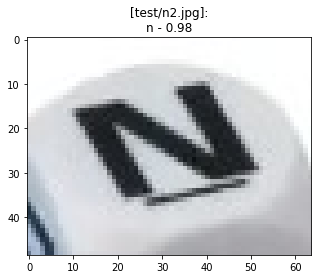

test/s.jpg
1/1 [==============================] - 0s 52ms/step



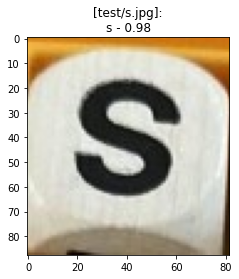

test/u.jpg
1/1 [==============================] - 0s 39ms/step



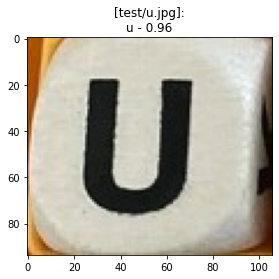

test/z.jpg
1/1 [==============================] - 0s 39ms/step



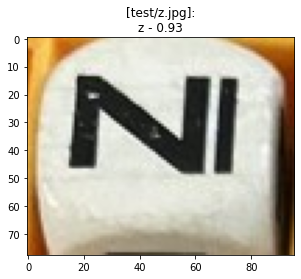

In [10]:
model = tf.keras.models.load_model(model_weights_best)

test_images = pathlib.Path("./test").glob('*.jpg')

for img_path in test_images:
    img_path = str(img_path).replace('\\', '/')
    print(img_path)
    img = tf.keras.utils.load_img(
        img_path, 
        target_size=(IMG_HEIGHT, IMG_HEIGHT), 
        color_mode="grayscale"
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])


    image_to_display = cv2.imread(img_path)
    image_to_display = cv2.cvtColor(image_to_display, cv2.COLOR_BGR2RGB)

    print()
    plt.imshow(image_to_display)
    plt.title("[{}]:\n{} - {:.2f}".format(img_path, CLASS_NAMES[np.argmax(score)],  10 * np.max(score)))
    plt.show()

### Convert from Keras model format to TFJS format


In [11]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, "./model_tfjs")